# Oblig 1

## MAT4110

### John-Magnus Johnsen

##### Thursday 25. september 2025

The idea of using QR factorisation to solve a system of linear equations is that from:
$$
\boldsymbol{Ax} = \boldsymbol{b}
$$ 

we factorize $\boldsymbol{A}$ into an orthogonal matrix $\boldsymbol{Q}$, and an upper triangular matrix $\boldsymbol{R}$, such that $\boldsymbol{A} = \boldsymbol{QR}$, and the expression becomes:
$$
\boldsymbol{QRx} = \boldsymbol{b} 
$$

First we write:

$$
\boldsymbol{Qy} = \boldsymbol{b}
$$

Where $\boldsymbol{y} = \boldsymbol{Rx}$. Then we left-multiply both sides by $\boldsymbol{Q}^T$:

$$
\boldsymbol{Q}^T \boldsymbol{Qy} = \boldsymbol{Q}^T \boldsymbol{b}
$$

And since $\boldsymbol{Q}$ is an orthogonal matrix, it will have the much helpful property of $\boldsymbol{Q}^T = \boldsymbol{Q}^{-1}$. 

So we then get:

$$
\boldsymbol{Q}^{-1} \boldsymbol{Qy} = \boldsymbol{Q}^T \boldsymbol{b}
$$

$$
\boldsymbol{y} = \boldsymbol{Q}^T \boldsymbol{b}
$$

Now, $\boldsymbol{Q}^T \boldsymbol{b}$ is straight forward solvable, therefore we easily obtain $\boldsymbol{y}$.

From this we can solve $\boldsymbol{Rx} = \boldsymbol{y}$, by <u>back substitution</u> since we know $\boldsymbol{R}$ is upper triangular, ultimately finding $\boldsymbol{x}$.

The idea behind this particularly implementation of the back substitution is to clean up the upper triangular matrix with row operations, so that we end up with only ones along the diagonal and zero elsewhere. Going from the augmented matrix $[\boldsymbol{R} \, \boldsymbol{y}] \rightarrow [\boldsymbol{I} \, \boldsymbol{\tilde y}]$, with the resulting vector $\boldsymbol{\tilde y}$ containing the values of $\boldsymbol{x}$ in perfect order, corresponding to $\boldsymbol{I} \boldsymbol{x} = \boldsymbol{\tilde y}$.

In [205]:
# 1. Back substitution function 

def back_substitution(U, y):
    """
    Calculate x from the expression Ux = y, by using back substitution.
    U is an upper triangular matrix, y a vector.
    Returns the vector x.
    """
    # Prepare U and y for back substitution
    n = np.shape(U)[0]  # number of rows in U
    m = np.shape(U)[1]  # number of columns in U
    # Create augmented matrix [U y], shape (n, m+1)
    Uy = np.zeros((n, m+1))
    Uy[:,:m] = U
    Uy[:,-1] = y

    # The back substitution
    # Solving the system Ux = y for x by back substitution, here by using row operations, Gauss elimination, on the augmented matrix [U y], 
    # which we turn into [I ~y], having the solution x = ~y
    for i in range(n):
        # Staring from the bottom row
        # First, find the the diagonal element of U in this row, use it to divide it self and the corresponding row element in y   
        pivot = np.copy(Uy[-1-i,-2-i])  # pivot element of row this row
                
        Uy[-1-i,-2-i] /= pivot          # the pivot element equals it self divided by the pivot element
        Uy[-1-i,-1] /= pivot            # the corresponding y value equals it self divided by the pivot element

        # Second, make all column elements above the pivot element zero by row operations, also updating y accordingly
        p_col = np.copy(Uy[:-1-i,-2-i]) # array of all column elements in column -2-i above row -1-i, -1-i is excluded
        y_pivot = np.copy(Uy[-1-i,-1])  # y value corresponding to pivot element

        # add the negative value of it self for all elements above pivot, essentially setting them to zero
        Uy[:-1-i,-2-i] = Uy[:-1-i,-2-i] + (-1.0*p_col)
        
        # for each y element above y_pivot, add the value of: y_pivot times the same value used above for det pivot column,
        # this corresponds to the same row operations the row with pivot element in question makes on the above rows
        Uy[:-1-i,-1] = Uy[:-1-i,-1] + (-1.0*p_col*y_pivot)
    
    x = Uy[:,-1]
    return x

Another way to solve the linear system is to look at the closed form solution to the sum of square errors between the predicted values and data, in other words the <i>normal equation</i>:
$$
\boldsymbol{A}^T \boldsymbol{A} \boldsymbol{x} = \boldsymbol{A}^T \boldsymbol{b}
$$

We first set $\boldsymbol{B} = \boldsymbol{A}^T \boldsymbol{A}$, and do a Cholesky factorization, first by having $ \boldsymbol{B} = \boldsymbol{L} \boldsymbol{D} \boldsymbol{L}^T$, where $\boldsymbol{L}$ is a lower triangular matrix and $\boldsymbol{D}$ a diagonal matrix, then since $\boldsymbol{B}$ is positive definite, $\boldsymbol{D}$ will have no negative or zero entries along the diagonal, so we can write: $\boldsymbol{D} = \boldsymbol{D}^{1/2} \boldsymbol{D}^{1/2}$, where $(\boldsymbol{D}^{1/2})_{k,k} = \sqrt{D_{k,k}}$. We have:
$$
\boldsymbol{B} = \boldsymbol{L} \boldsymbol{D}^{1/2} \boldsymbol{D}^{1/2} \boldsymbol{L}^T = (\boldsymbol{L} \boldsymbol{D}^{1/2}) \left( \boldsymbol{L} ((\boldsymbol{D}^{1/2}))^T \right)^T
$$

Which, do to $\boldsymbol{D}$ being a diagonal matrix - thus invariant under transposition: $\boldsymbol{D}^T = \boldsymbol{D}$, can be written:
$$
B = \boldsymbol{L} \boldsymbol{D}^{1/2} \left( \boldsymbol{L} \boldsymbol{D}^{1/2} \right)^T
$$

Sometimes written, with $\boldsymbol{R} = \boldsymbol{L} \boldsymbol{D}^{1/2}$, so that:
$$
\boldsymbol{B} = \boldsymbol{R} \boldsymbol{R}^T 
$$
 
This lets us go from:
$$
\boldsymbol{B} \boldsymbol{x} = \boldsymbol{A}^T \boldsymbol{b}
$$

To:
$$
\boldsymbol{R} \boldsymbol{R}^T \boldsymbol{x} = \boldsymbol{A}^T \boldsymbol{b}
$$

The entries in $\boldsymbol{L}$ is only scaled by multiplication with $\boldsymbol{D}^{1/2}$, so $\boldsymbol{R}$ remains lower triangular, while $\boldsymbol{R}^T$ is upper triangular. And similar to the QR factorization above, we can solve this in two steps, first by making the substitution $\boldsymbol{R}^T \boldsymbol{x} = y$:
$$
\boldsymbol{R} \boldsymbol{y} = \boldsymbol{A}^T \boldsymbol{b}
$$

Solving for $\boldsymbol{y}$ through <u>forward substitution</u> this time (since $\boldsymbol{R}$ i lower triangular, and $\boldsymbol{A}^T \boldsymbol{b}$ easily can be computed), and then once we have $\boldsymbol{y}$ we can solve:
$$
\boldsymbol{R}^T \boldsymbol{x} = y
$$
by using <u>back substitution</u> (since $\boldsymbol{R}^T$ is upper triangular), finally obtaining $\boldsymbol{x}$.

For the forward substitution we follow a more conventional algorithm, like the one presented in the book. This algorithm exploits that we for a lower triangular matrix $\boldsymbol{L}$, and $\boldsymbol{Lx} = \boldsymbol{y}$, obtain the first element of $\boldsymbol{x}$, $x_1$, from $A_{1,1} x_1 = y_1 \implies x_1 = \dfrac{y_1}{A_{1,1}}$. Then because $\boldsymbol{A}$ is lower triangular we will always have alle the elements to the left of the pivot element (diagonal element) calculated going down the diagonal.

In [206]:
# 2. Cholesky factorization function and forward substitution function

def cholesky_factorization(A):
    """
    Decomposes A into a lower triangular matrix L, the diagonal matrix D, and the upper triangular matrix L.transpose
    In this case, A must be symmetric, and can't have non zero entries along the diagonal.
    Returns R, and R transposed 
    """
    # First a LDL.T composition.
    if np.shape(A)[0] != np.shape(A)[1]:
        raise ValueError("A must be square")

    n = np.shape(A)[1]  # the number of columns in A    
    L = np.zeros([n ,n])
    D = np.zeros([n, n])

    A_current = np.array(A, dtype=float)    # so to not cause int error further down the code
    for k in range(n):
        L[:,k] = np.copy(A_current[:,k])    # the k-th column of L equals the k-th column of A
        
        if L[k,k] == 0:
            raise ValueError("Matrix A might be singular or not positive definite.")    # Also prevent division by zero bellow
        
        L[:,k] /= L[k,k]                    # scale the k-th column of L with the diagonal element L[k,k]
        D[k,k] = A_current[k,k]
        A_current -= D[k,k]*np.outer(L[:,k], L[:,k].T)

    # The Cholesky factorization A = RR.T
    R = L @ np.sqrt(D)
    
    return R, R.T

def forward_substitution(L, y):
    """
    Calculate x in Lx = y, where L is an lower triangular matrix, by forward substitution.
    Take lower triangular matrix L, and vector y.
    Return column vector x.
    """
    n = L.shape[0]
    m = L.shape[1]
    if n != m:
        raise ValueError("L is not a square matrix")
    
    if len(y) != n:
        raise ValueError(f"y must be a vector of length {n}")
    
    x = np.zeros([n])

    if abs(L[0,0]) > 1e-12:
        x[0] = y[0]/L[0,0]
    else:
        raise ValueError("Diagonal element L[0,0] is zero")
    
    for i in range(1, n):
        if L[i,i] > 1e-12:

            temp = 0
            for j in range(0, i):
                temp = temp + L[i,j] * x[j]
            
            x[i] = (y[i] - temp/L[i,i])
        else:
            raise ValueError(f"Diagonal element L[{i},{i}] is zero")

    return x

In [207]:
import numpy as np
import matplotlib.pyplot as plt

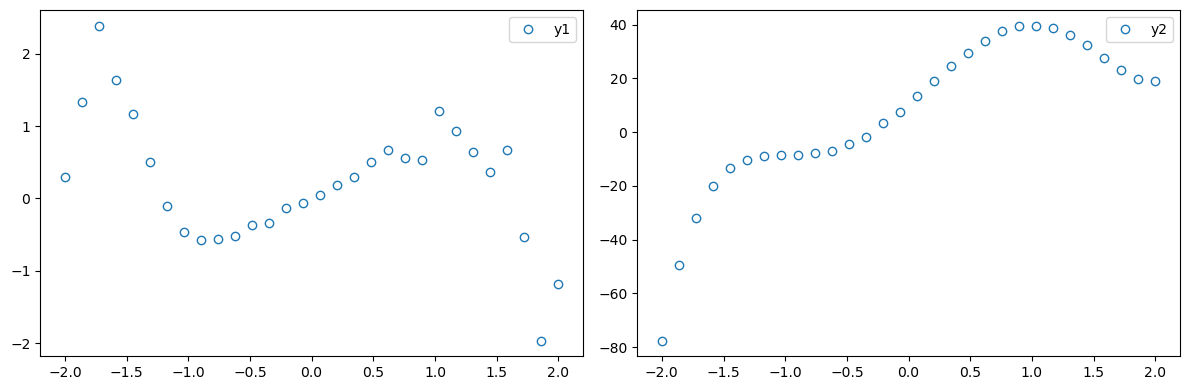

In [208]:
# Generating the data
n = 30
start = -2
stop = 2
x = np.linspace(start,stop,n)

eps = 1
np.random.seed(1)
r = np.random.rand(1,n) * eps

y1 = x*(np.cos(r + 0.5*x**3) + np.sin(0.5*x**3))
y2 = y = 4*x**5 - 5*x**4 - 20*x**3 + 10*x**2 + 40*x + 10 + r

# Plotting the data
y1 = np.ravel(y1) # flattens the array to 1D for plotting
y2 = np.ravel(y2)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

ax1.plot(x, y1, "o", label="y1", markerfacecolor='none')
ax1.legend()
ax2.plot(x, y2, "o", label="y2", markerfacecolor='none')
ax2.legend()

plt.tight_layout()
plt.show()
plt.close()

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Create a feature (or design) matrix A using the scikit learn library, containing the columns [1, x, x^2, x^3 .. x^n] 
m = 3   # Columns of A
poly = PolynomialFeatures(m-1)    # for polynomial degree m-1
A_m3 = poly.fit_transform(x.reshape(-1,1)) # feature matrix A_m3 with poly degree 2, first explicitly turn x into a column vector

# Performing the QR factorization using the numpy library, m = 3
Q, R = np.linalg.qr(A_m3)  # numpy function calculating Q and R
# Looking at y1 data
b1 = y1  
y = Q.T @ b1 # matrix multiplication between the transpose of Q and vector b
# Using back substitution finding x in Rx
x1_m3 = back_substitution(R, y)
prediction_m3_y1 = A_m3 @ x1_m3
# Looking at y2 data
b2 = y2
y = Q.T @ b2 # matrix multiplication between the transpose of Q and vector b
# Using back substitution finding x in Rx
x2_m3 = back_substitution(R, y)
prediction_QR_m3_y2 = A_m3 @ x2_m3

# Cholesky factorization, m = 3
B_m3 = A_m3.T @ A_m3
R, RT = cholesky_factorization(B_m3)
# Solving the system
y1_cholesky = forward_substitution(R, A_m3.T @ y1)
x1_cholesky_y1 = back_substitution(RT, y1_cholesky)
prediction_cholesky_m3_y1 = A_m3 @ x1_cholesky_y1

y2_cholesky = forward_substitution(R, A_m3.T @ y2)
x2_cholesky_y2 = back_substitution(RT, y2_cholesky)
prediction_cholesky_m3_y2 = A_m3 @ x2_cholesky_y2

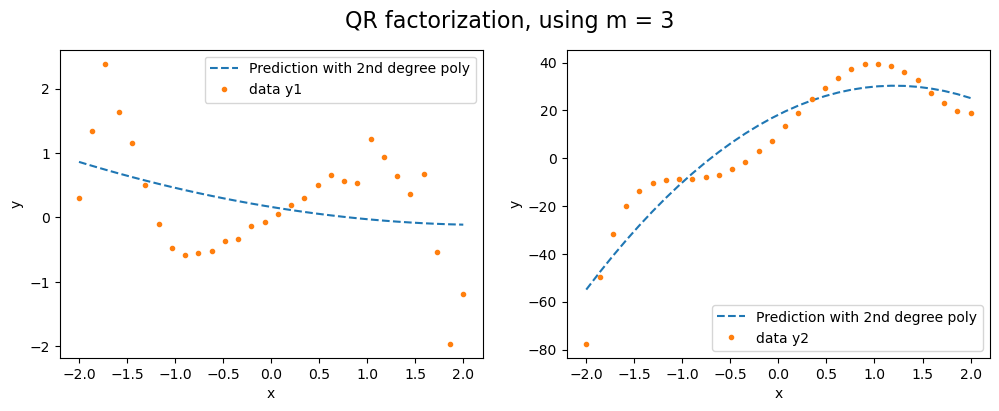

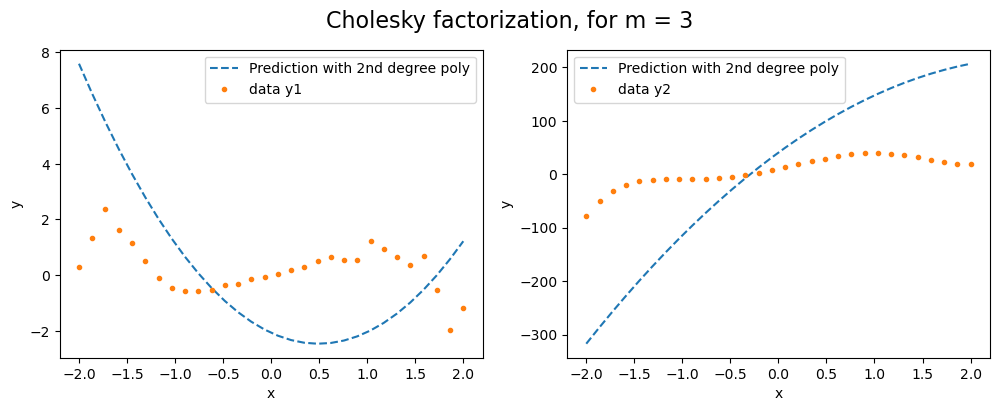

In [210]:
# Plotting QR, m = 3
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax1.plot(A_m3[:,1], prediction_m3_y1, "--", label=f"Prediction with {m-1}nd degree poly")
ax1.plot(x, y1, ".", label="data y1")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.legend()
ax2.plot(A_m3[:,1], prediction_QR_m3_y2, "--", label=f"Prediction with {m-1}nd degree poly")
ax2.plot(x, y2, ".", label="data y2")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.legend()
fig.suptitle(f"QR factorization, using m = {m}", fontsize=16)
plt.xlabel("x")
plt.ylabel("y")
plt.show()
plt.close()

# Plotting Cholesky, m = 3
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax1.plot(A_m3[:,1], prediction_cholesky_m3_y1, "--", label=f"Prediction with {m-1}nd degree poly")
ax1.plot(x, y1, ".", label="data y1")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.legend()
ax2.plot(A_m3[:,1], prediction_cholesky_m3_y2, "--", label=f"Prediction with {m-1}nd degree poly")
ax2.plot(x, y2, ".", label="data y2")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.legend()
fig.suptitle(f"Cholesky factorization, for m = {m}", fontsize=16)
plt.xlabel("x")
plt.ylabel("y")
plt.show()
plt.close()

In [ ]:
m = 8   # Columns of A
# Create a feature (or design) matrix A using the scikit learn library, containing the columns [1, x, x^2, x^3 .. x^n] 
poly = PolynomialFeatures(m-1)    # for polynomial degree m-1
A_m8 = poly.fit_transform(x.reshape(-1,1)) # feature matrix A_m8 with poly degree 2, first explicitly turn x into a column vector

# Performing the QR factorization of A_m8 using the numpy library
Q, R = np.linalg.qr(A_m8)  # numpy function calculating Q and R
# Looking at y1 data
b1 = y1  
y = Q.T @ b1 # matrix multiplication between the transpose of Q and vector b
# Using back substitution finding x in Rx
x1_m8 = back_substitution(R, y)
prediction_m8_y1 = A_m8 @ x1_m8
# Looking at y2 data
b2 = y2
y = Q.T @ b2 # matrix multiplication between the transpose of Q and vector b
# Using back substitution finding x in Rx
x2_m8 = back_substitution(R, y)
prediction_QR_m8_y2 = A_m8 @ x2_m8

# Cholesky factorization
B_m8 = A_m8.T @ A_m8
R, RT = cholesky_factorization(B_m8)
y1_cholesky = forward_substitution(R, A_m8.T @ y1)
x1_cholesky_y1 = back_substitution(RT, y1_cholesky)
prediction_cholesky_m8_y1 = A_m8 @ x1_cholesky_y1
# Solving the system
y2_cholesky = forward_substitution(R, A_m8.T @ y2)
x2_cholesky_y2 = back_substitution(RT, y2_cholesky)
prediction_cholesky_m8_y2 = A_m8 @ x2_cholesky_y2

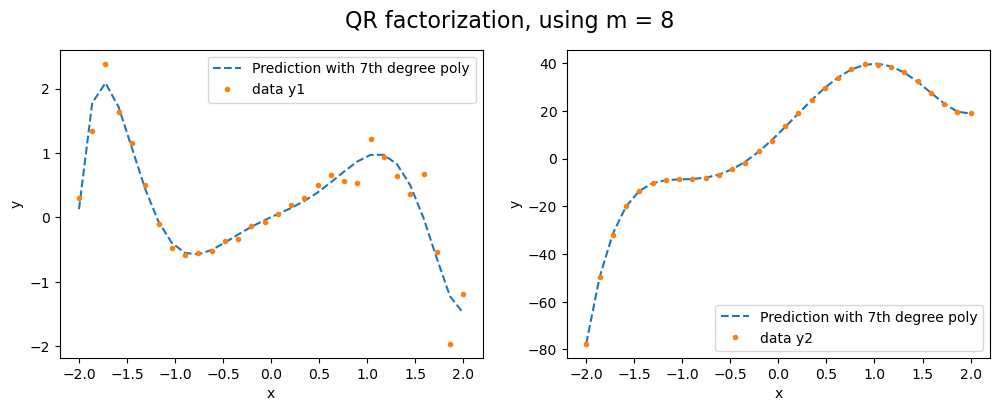

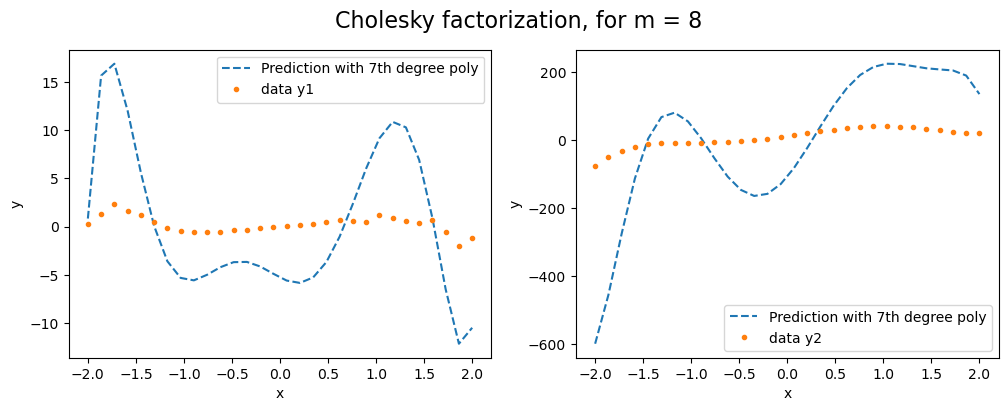

In [212]:
# Plotting QR, m = 8
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax1.plot(A_m8[:,1], prediction_m8_y1, "--", label=f"Prediction with {m-1}th degree poly")
ax1.plot(x, y1, ".", label="data y1")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.legend()
ax2.plot(A_m8[:,1], prediction_QR_m8_y2, "--", label=f"Prediction with {m-1}th degree poly")
ax2.plot(x, y2, ".", label="data y2")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.legend()
fig.suptitle(f"QR factorization, using m = {m}", fontsize=16)
plt.xlabel("x")
plt.ylabel("y")
plt.show()
plt.close()

# Plotting Cholesky, m = 8
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax1.plot(A_m8[:,1], prediction_cholesky_m8_y1, "--", label=f"Prediction with {m-1}th degree poly")
ax1.plot(x, y1, ".", label="data y1")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.legend()
ax2.plot(A_m8[:,1], prediction_cholesky_m8_y2, "--", label=f"Prediction with {m-1}th degree poly")
ax2.plot(x, y2, ".", label="data y2")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.legend()
fig.suptitle(f"Cholesky factorization, for m = {m}", fontsize=16)
plt.xlabel("x")
plt.ylabel("y")
plt.show()
plt.close()

We see that for the QR method we get a good fit for both polynomials that captures the essence in the data well. But for Cholesky the fit seems to amplify on the peaks and dips of the data. For $m=3$ the shape of the prediction is similar to that of QR, but for $m=8$ the prediction is way off the data. The Cholesky factorization of $\boldsymbol{B} = \boldsymbol{A}^T \boldsymbol{A}$, relies on the multiplication of the two design-matrices that run the risk of having entries with small numbers getting close to zero in $\boldsymbol{B}$. Therefore important information might be lost in this step. Calculating the condition-number of $\boldsymbol{A}$ can tell us if the matrices is so called well or ill condition for futher calculation, where higher numbers goes in the direction of ill conditioning.

In [213]:
cond_A3 = np.linalg.cond(A_m3, p=2)
print(f"Condition number p=2 norm, for A_m3: {cond_A3}")

cond_A8 = np.linalg.cond(A_m8, p=2)
print(f"Condition number p=2 norm, for A_m8: {cond_A8}")

Condition number p=2 norm, for A_m3: 3.35669965443501
Condition number p=2 norm, for A_m8: 508.86542705418844


Using numpy functionality for calculating the condition number of $\boldsymbol{A}$, we see that for $m = 8$, the condition number is two order of magnitudes greater than for $m = 3$.